# Определение перспективного прадаж для интернет-магазина «Стримчик»

В данной работе нам необходимо продумать рекламную компанию на следующий год. Необходимо отработать принцип работы с данными.

## Изучение данных из файла

In [1]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats as st
import numpy as np

Получим файл с даннымм

In [2]:
def return_df (name_csv):
    try:
        return pd.read_csv(name_csv)
    except:
        print('Не удалось найти файл по заданному пути.')

In [3]:
game_data = return_df('/datasets/games.csv')

In [4]:
# выведем нашу таблицу
game_data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [5]:
game_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В нашей таблице 11 колонок:
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Количество значений в столбцах различается, это говорит о том, что в нашей таблице есть пропуски. Давайте разберемся с ними.

## Подготовка данных

### Замените названия столбцов

In [6]:
# выведем названия столбцов
game_data.columns 

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

Для удобства приведем названия к нижнему регистру и немного отредактируем их.

In [7]:
game_data.columns = ['game_name', 'platform', 'year_of_release', 'genre_name', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']

### Заполним пропуски

На первом этапе мы заметили, что в наших колонках заполненно разное количество значений. Это значит, что в данных есть пропуски. Наглядно вывелдем их количество.

In [8]:
report = game_data.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / game_data.shape[0]).round(2)
report.style.background_gradient(cmap = 'RdPu')

,missing_values,% of total
game_name,2,0
platform,0,0
year_of_release,269,0.02
genre_name,2,0
na_sales,0,0
eu_sales,0,0
jp_sales,0,0
other_sales,0,0
critic_score,8578,0.51
user_score,6701,0.4


Пропусков в столбце 'name' всего 2, это меньше процента. Название игр у всех разное, заполнить эти значения мы не сможем, так что придется их удалить.

In [9]:
game_data['game_name'].fillna('game_name', inplace = True)

В столбце 'year_of_release' тоже есть пропуски. Они оставляют 2% от общего количества строк. От этих пропусков я избавлюсь, 2% это не много. А данные этого столбца для нас очень важны, дальнейших анализ будет проходить на их основе.

In [10]:
game_data.dropna(subset = ['year_of_release'], inplace = True)

Дальше рассмотрим 3 столбца: 'critic_score', 'user_score', и 'rating'. В первом хранятся значения оценки критиков, во втором оценки пользователей, а в третьем столбце названия рейтинга, к которому игру присвоила организация ESRB. Не будем удалять все эти строки с пропусками, ведь так мы потеряем большую часть информации. Все значения предлагаю заполнить маркерами, которые будут нам говорить о том, что значения были пропущены. В столбцах 'critic_score', 'user_score' используем нули в виде маркера, а в столбце 'rating' пропущенные значения заменим словом 'unkown'.

In [11]:
# заполним пропуски 
for column in ['critic_score','user_score']:
    game_data[column].fillna(0, inplace = True)

In [12]:
game_data['rating'].fillna('unknown', inplace = True)

Так же в столбце 'user_score' запряталось странное значение 'tbd'. Так как этот столбец хранит оценки рейтинга от 1 до 10, это значение нам не подходит, похоже на ошибку. Будем считать его за пропуски и тоже заполним его на 0.

In [13]:
game_data['user_score'] = game_data['user_score'].replace('tbd', '0')

Избавились от наших пропусков, давайте посмотрим, в каких типах хранятся наши данные.

### Преобразуем данные в нужные типы

Вспомним, какие данные хранятся в наших столбцах.

In [14]:
game_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
game_name          16446 non-null object
platform           16446 non-null object
year_of_release    16446 non-null float64
genre_name         16444 non-null object
na_sales           16446 non-null float64
eu_sales           16446 non-null float64
jp_sales           16446 non-null float64
other_sales        16446 non-null float64
critic_score       16446 non-null float64
user_score         16446 non-null object
rating             16446 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


В некоторых столбцах данные надо конвертировать в нужный тип. Столбцы 'year_of_release' и 'critic_score' преобразуйте к типу 'int'. А столбец 'user_score' приведем к типу float.

In [15]:
game_data['user_score'] = game_data['user_score'].astype('float')

In [16]:
for column in ['year_of_release','critic_score']:
    game_data[column] = game_data[column].astype('int')

In [17]:
game_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
game_name          16446 non-null object
platform           16446 non-null object
year_of_release    16446 non-null int64
genre_name         16444 non-null object
na_sales           16446 non-null float64
eu_sales           16446 non-null float64
jp_sales           16446 non-null float64
other_sales        16446 non-null float64
critic_score       16446 non-null int64
user_score         16446 non-null float64
rating             16446 non-null object
dtypes: float64(5), int64(2), object(4)
memory usage: 1.5+ MB


Теперь наши данные выглядят намного лучше. Осталось выполнить некоторые расчеты и можно переходить к анализу.

### Проведем расчеты

Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец. Для этого напишем метод, который будет складывать сумму продаж на всех территориях и возвращать её.

In [18]:
def sum_sales(raw):
    return raw['na_sales'] + raw['eu_sales'] + raw['jp_sales'] + raw['other_sales']

In [19]:
game_data['total_sales'] = game_data.apply(sum_sales, axis = 1)

In [20]:
game_data.head(10)

,game_name,platform,year_of_release,genre_name,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,0.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,unknown,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,0,0.0,unknown,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,0,0.0,unknown,28.31


### Вывод

На этом этапе мы подготовили наши данные к дальнейшей работе. Провели предобработку наших данных. Отредактировали названия колонок, заполнили пропуски, переопределили типы данных наших данных. Затем мы создали столбец 'total_sales'. В нём хранятся данные о суммарных продажах во всех регионах.

## Исследовательский анализ данных

На этом этапе мы углубимся в наши данные. Будим изучать статистику по прадажам игр в разные годы.

Сначала рассчитаем, сколько игр выпускались в разные годы.

In [21]:
# заранее определим стиль для наших графиков
plt.style.use('ggplot')

In [65]:
games_per_year = game_data.pivot_table(
    index = 'year_of_release',values = 'game_name', aggfunc = 'count'
).rename(columns = {'game_name': 'game_count'})

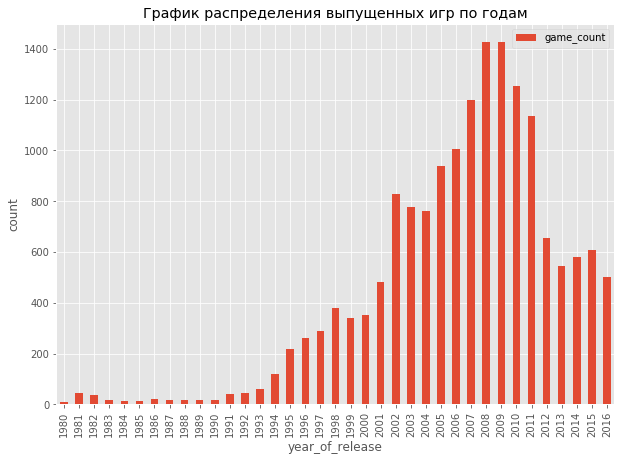

In [23]:
# отобразим полученную таблицу в графике
games_per_year.query('year_of_release != 0').plot.bar(
    figsize=(10, 7)
);
plt.ylabel('count')
plt.title('График распределения выпущенных игр по годам');

О чем нам говорит наш график? С 1980 по 1993 года игровая индустрия только начала развиваться, до 2000х годов игр выпускалось мало, так что этот период нам не поможет в прогнозировании. По сей день компьютерный игры пользуются большим сроком, но пик своей популярности уже прошел. Больше всего игр выпустили в 2008-2009 годах, сейчас в год выпускают на порядок меньше игр.

In [66]:
# уберем лишние данные
game_data = game_data.query('year_of_release >= 1993 ')

In [67]:
game_data

,game_name,platform,year_of_release,genre_name,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,unknown,31.38
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,0,0.0,unknown,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,0,0.0,unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,0,0.0,unknown,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,0,0.0,unknown,0.01


Теперь соберем информацию по каждой игровой платформе: 
* сколько игр вышло на этой платформе
* год выпуска первой игры
* год выпуска последней игры
* посчитаем значения, какой период платформа была актуальна (период времени с момента выпуска первой игры, до момента выпуска последней игры)

In [26]:
# рассчитаем для каждой платформы количество игр, выпущенных для неё, и год выпуска первой и последней игры
top_platforms = game_data.query('year_of_release != 0').pivot_table(
    index = 'platform', values = 'year_of_release', aggfunc = ['count','min', 'max']
)
top_platforms.columns = ['game_count','first_year','last_year']
# добавим столбце с периодом жизни (актуальности) платформы
top_platforms['total_lived'] = top_platforms['last_year'] - top_platforms['first_year']
top_platforms

,game_count,first_year,last_year,total_lived
platform,,,,
3DO,3,1994,1995,1
3DS,512,2011,2016,5
DC,52,1998,2008,10
DS,2120,2004,2013,9
GB,67,1994,2001,7
GBA,811,2000,2007,7
GC,542,2001,2007,6
GEN,21,1993,1994,1
N64,316,1996,2002,6


Ещё добавим в нашу таблицу данные о продажах каждой платформы. Для этого посчитаем суммарные продажи всех игр для каждой платформы, а затем методом join() добавим их к нашей таблице.

In [27]:
platforms_sales = game_data.pivot_table(
    index = 'platform', values = 'total_sales', aggfunc = 'sum'
)

In [28]:
top_platforms = top_platforms.join(platforms_sales, how='outer')

In [68]:
top_platforms.sort_values(by = 'total_sales', ascending = False, inplace = True)

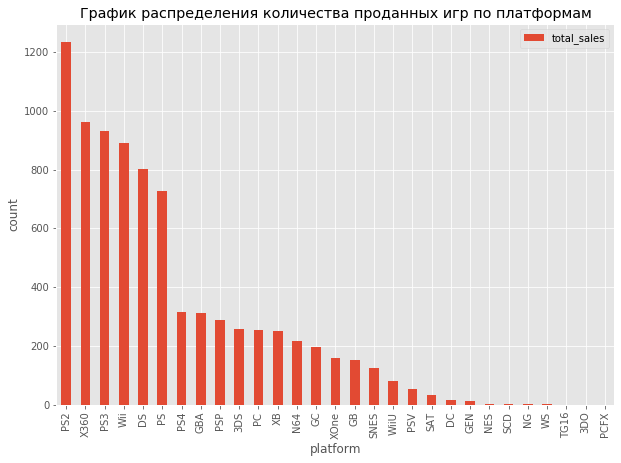

In [30]:
top_platforms.plot.bar(
    y = 'total_sales',
    figsize=(10, 7)
);
plt.ylabel('count')
plt.title('График распределения количества проданных игр по платформам');

Это рейтинг самых прибыльных платформ, с подробной информацией. Теперь давайте рассмотрим 6 самых прибыльных (бёрем именно 6, т.к. дальше на нашем графике наблюдается резкий спад), это 'PS2', 'X360', 'PS3', 'Wii', 'DS' и 'PS'. Построим для них распределение суммарных продаж по годам. И ответим на вопрос За какой характерный срок появляются новые и исчезают старые платформы?

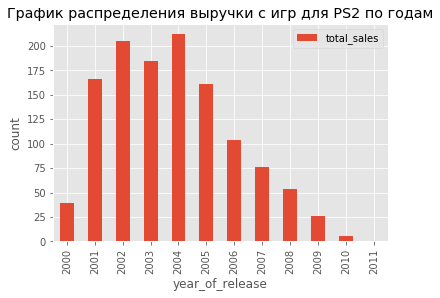

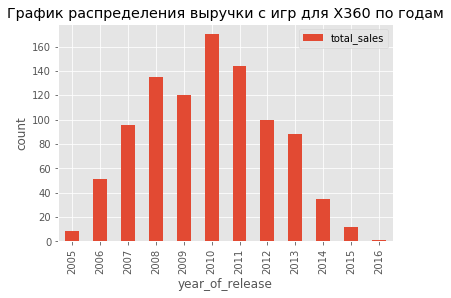

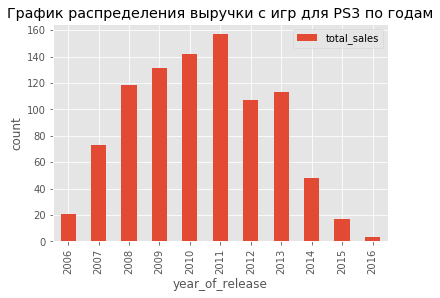

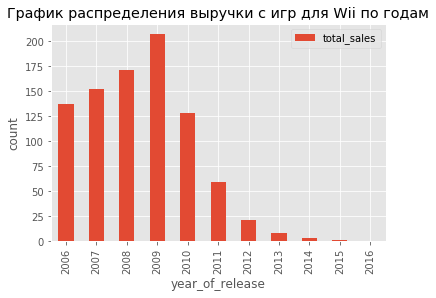

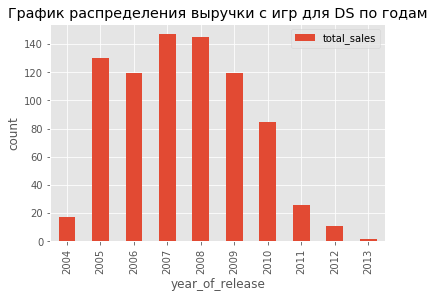

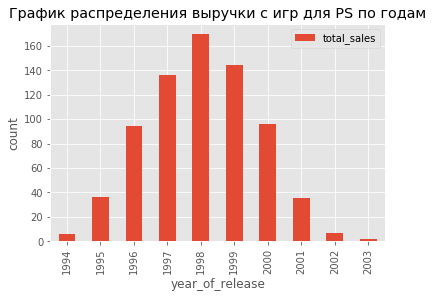

In [31]:
for platform in [ 'PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']:
    game_data.query('platform == @platform').pivot_table(
        index = 'year_of_release', values = 'total_sales', aggfunc = 'sum'
    ).query('year_of_release != 0').plot.bar();
    plt.ylabel('count')
    plt.title(f'График распределения выручки с игр для {platform} по годам');
    

Сначала хочется сказать о последнем графике: "График распределения выручки с игр для DS по годам". На этом графике видно, что первая игра на DS вышла ещё в 1985 году, а следующую игру выпустили лишь в 2004 году. Этот факт выглядит неправдоподобно, так что будем считать, что первая игра на DS вышла в 2004 году.

Что можно подметить, посмотрев на эти графики? Период выпуска игр на приставку 9-11 лет. Из них самый активный период продаж составляет около 5 лет, обычно пик продаж наступает за 1-2 года после появления новой платформы. Так что на часть вопроса: за какой характерный срок исчезают старые платформы, мы ответили. Примерно за 10 лет после выпуска. 

Теперь давайте вернемся к нашей таблице с информацией о продаже игр для каждой платформы и попробуем ответить на вопрос: За какой характерный срок появляются новые платформы? Для этого вспомним данные из нашего рейтинга платформ, отсортируем их по году выпуска первой игры, так как игровая индустрия начала существенно расширятся примерно с 2000х годов, отсеем все платформы, на которые выпустили последнюю игру до 2000 года. 

In [32]:
# вспомним данные из нашего рейтинга, отсротируемих по году выпуска первой игры
top_platforms_2000 = top_platforms.query('first_year >= 2000').sort_values(by = 'first_year')

Теперь, чтобы все-таки ответить на вопрос: за какой характерный срок появляются новые платформ, посчитаем по нашей выборке, сколько новых приставок появилось за период с 2000 по 2016 год. Рассчитаем количество приставок, появляющиеся каждый год.

In [33]:
period = [2000, 2016]
print(f'За период с {period[0]} по {period[1]} ({period[1] - period[0] + 1} лет) год появиилось {len(top_platforms_2000)} новых платформ')
print(f'За период с {period[0]} по {period[1]} ({period[1] - period[0] + 1} лет) в год появлялось {len(top_platforms_2000) /(period[1] - period[0] + 1):.2f} новых платформ')

За период с 2000 по 2016 (17 лет) год появиилось 14 новых платформ
За период с 2000 по 2016 (17 лет) в год появлялось 0.82 новых платформ


Какой вывод можно из этого сделать? Новая платформа появляется примерно каждые 16 месяцев.

Теперь выберем из общего рейтинга те платформы, на которые ещё выпускают игры (значение 'last_year' == 2016). Дальше в анализе будем использовать эти данные.

In [34]:
actual_statistics = top_platforms.query('last_year == 2016')
actual_statistics

,game_count,first_year,last_year,total_lived,total_sales
platform,,,,,
X360,1232,2005,2016,11,961.24
PS3,1306,2006,2016,10,931.34
Wii,1286,2006,2016,10,891.18
PS4,392,2013,2016,3,314.14
3DS,512,2011,2016,5,257.81
PC,950,1994,2016,22,252.66
XOne,247,2013,2016,3,159.32
WiiU,147,2012,2016,4,82.19
PSV,429,2011,2016,5,53.81


Лидеры по продажам у нас: 'X360', 'PS3' и 'Wii'. По суммарным продажам они не сильно отличаются, но на порядок опережают своих конкурентов.
Лидеры по продажам за все время своего существования у нас: 'X360', 'PS3' и 'Wii'. По суммарным продажам они не сильно отличаются, но на порядок опережают своих конкурентов. Но на рынке все эти платформы существуют разное количество времени. Давайте для каждой из актуальных платформ построим графики со значениями суммарных продаж по годам. Посмотрим, какие из них растут, а какие в упадке. Выберем несколько потенциально прибыльных платформ.


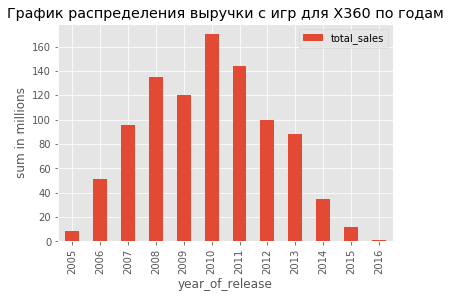

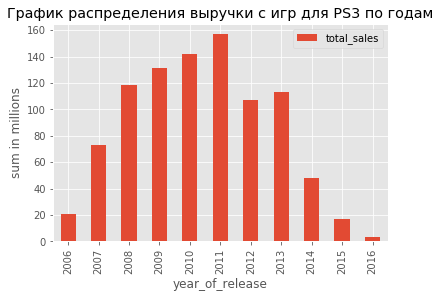

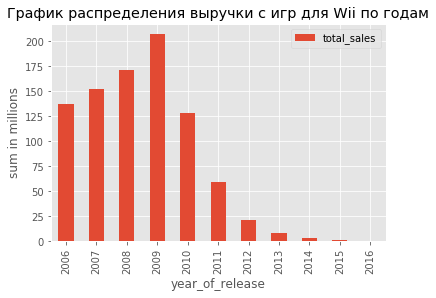

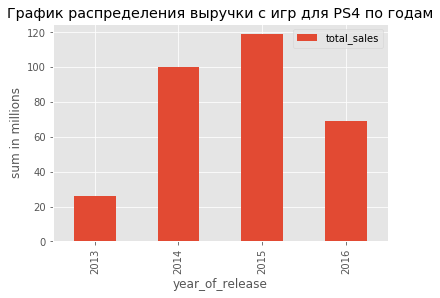

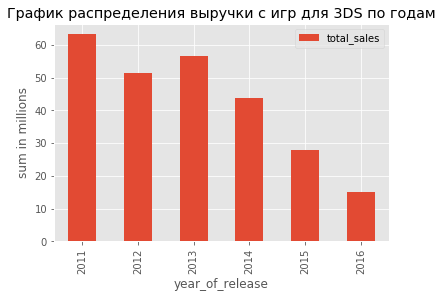

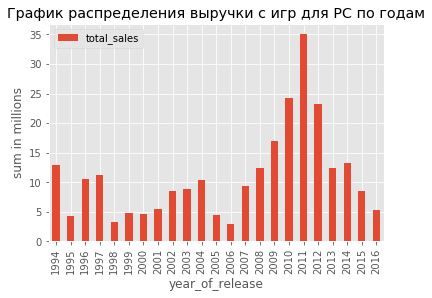

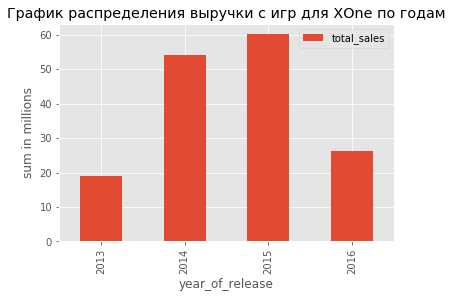

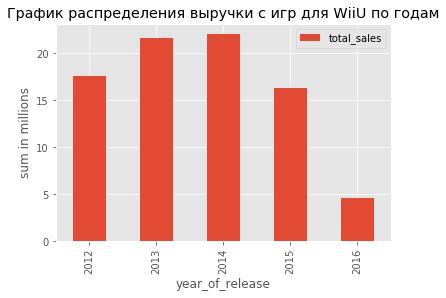

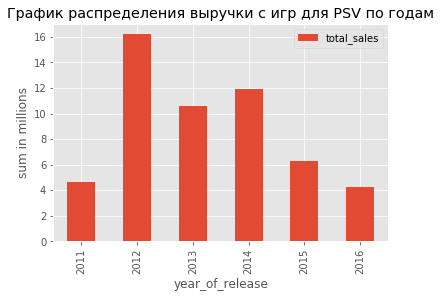

In [35]:
for platform in actual_statistics.index:
    game_data.query('platform == @platform').pivot_table(
        index = 'year_of_release', values = 'total_sales', aggfunc = 'sum'
    ).query('year_of_release != 0').plot.bar();
    plt.ylabel('sum in millions')
    plt.title(f'График распределения выручки с игр для {platform} по годам');
    plt.show();


Некоторые приставки: 'X360', 'PS3' и 'Wii' - существуют на рынке уже достаточно давно, они уже пережили пик своей популярности и в их жизнь подходит к закату популярности. В этот перечень я не засунул 'PC', так компьютеры постоянно улучшается, становятся мощнее, так что новые игры всегда можно сделать и для 'PC'. Факт, что сейчас игры для персонального компьютера пользуются меньшей популярностью, чем в 2011 году, но пользоваться спросом игры на PC будут ещё очень долго. Но я бы не рассчитывал на новый скачок продаж, так как игры начинают переезжать на консоли, которые специально создаются для этого.

На какие платформы можно сделать ставку? Точно я бы сделал ставку на 'PS4' и 'XOne', хоть и в последнем году продажи на эти платформы немного просели, но по этим данным нельзя сказать, что у этих консолей начинается спад. Я в них не сомневаюсь, так как их предшественники (старые консоли от тех же компаний): 'PS2', 'PS3' и 'X360' - это платформы, которые находятся в лидерах по продаже игр. У этих консолей есть известное имя, из-за которых пользователь будет выбирать их из множества всех.


In [36]:
platform_size = (
    ['X360', 3],
    ['PS3', 3], 
    ['Wii', 2], 
    ['PS4', 2], 
    ['PC', 0.5], 
    ['3DS', 1], 
    ['XOne', 2], 
    ['WiiU', 1.5], 
    ['PSV', 0.5]
)

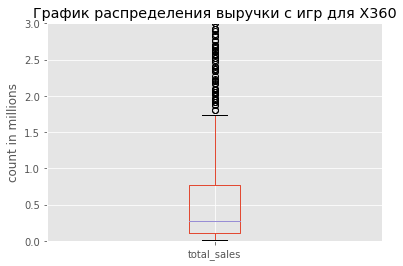

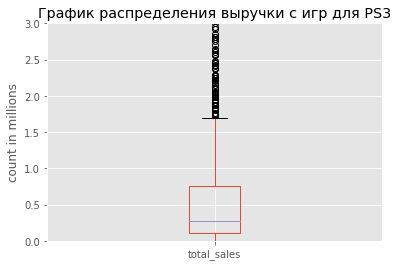

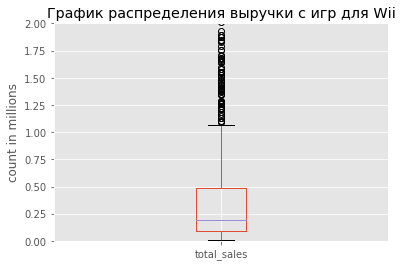

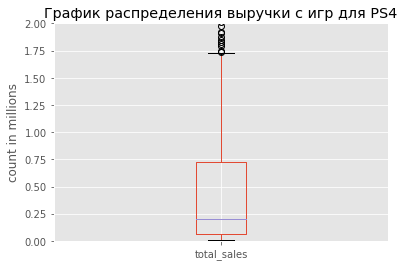

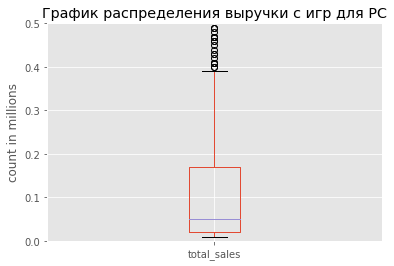

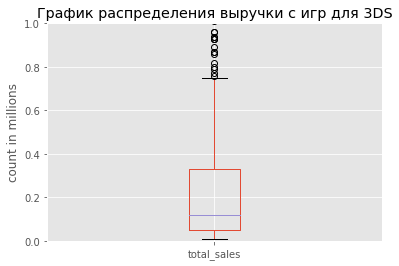

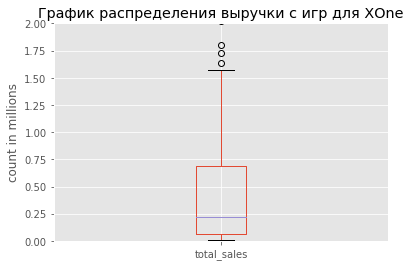

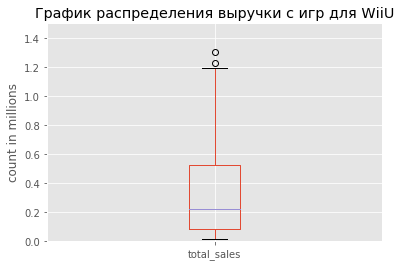

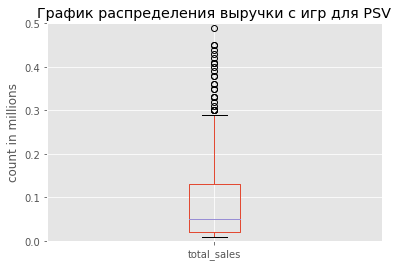

In [37]:
for platform, ymax in platform_size:
    plt.ylim(0, ymax)
    game_data.query('platform == @platform')['total_sales'].to_frame().boxplot()
    plt.ylabel('count in millions')
    plt.title(f'График распределения выручки с игр для {platform}');
    plt.show()

(0, 1)

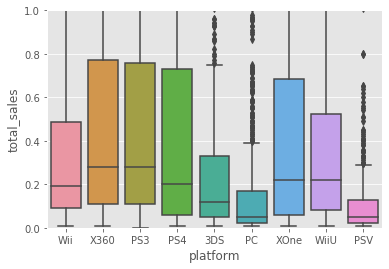

In [38]:
# для удобного сравнения построим все boxplot на одном графике
sns.boxplot(x='platform', y='total_sales', data=game_data.query(
    'platform in @actual_statistics.index'
))
plt.ylim(0, 1)

Теперь мы видим, что, вне зависимости от платформы, большая часть значений лежит в диапазоне, который не превышает 1 млн шт. На некоторых платформах большая часть лежит в диапазоне в 0.15 млн. шт, а у некоторых платформ 0.8 млн. шт. Теперь нам легче сделать прогноз для новой консоли. Из всех новых платформ в лидерах 'PS4' и 'XOne', так же можно понадеется на игры для 'WiiU', но они с меньшей вероятностью принесут такое большое количество продаж, как фавориты. А вот '3DS' и 'PSV' оставляют желать лучшего, продают они меньше всего.

Вывод на следующий год очень даже хорош. У нас есть две молодые и перспективные консоли, а также одна черная лошадка, которая тоже может показать себя в продажах.

Тепере изучим зависимость продаж от отзывов пользователей и критиков на примере платформы 'PS2'. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

In [39]:
# выберем только игры для платформы 'PS2'
PS2_stat = game_data.query('platform == "PS2"')

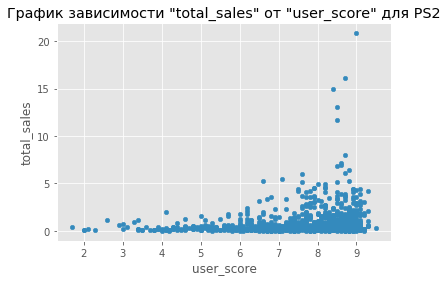

In [40]:
PS2_stat.query('user_score != 0').plot.scatter(
    x = 'user_score',
    y = 'total_sales',
);
plt.title(f'График зависимости "total_sales" от "user_score" для PS2');

In [41]:
#коэффициент корреляции суммы продаж от оценки пользователей 
PS2_stat['total_sales'].corr(PS2_stat['user_score'])

0.26391805692099385

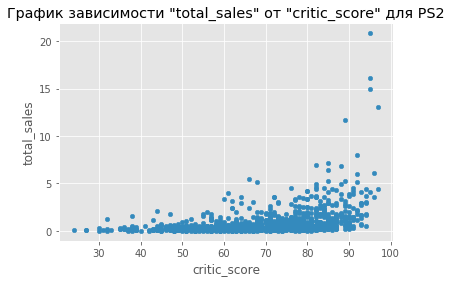

In [42]:
PS2_stat.query('critic_score != 0').plot.scatter(
    x = 'critic_score',
    y = 'total_sales',
);
plt.title(f'График зависимости "total_sales" от "critic_score" для PS2');

In [43]:
#коэффициент корреляции суммы продаж от оценки критиков
PS2_stat['total_sales'].corr(PS2_stat['critic_score'])

0.30095304085458136

Какой вывод можно сделать? Вне зависимости от оценки критиков или игроков, игры могут плохо продаваться. Значения корреляции в обоих случаях мало, 0.3 и 0.26. Но на Диаграмме размаха видно, что у всех выдающихся игр (игры, которые принесли большую прибыль), имеют хорошую оценку, как от пользователей, так и от критиков. Тут нет казуальности, скорее всего логика здесь очень простая. Перед покупкой игры люди тщательно её изучают, они не хотят покупать непонятно что. Поэтому и выдающиеся игры приносят большую выручку.

Давайте возьмем две другие популярные платформы, 'XOne' и 'PS3' и проведем с ними тот же эксперимент. Чтобы проверить правдивость нашего вывода.

In [44]:
# создадим выборки только игры для платформы 'XOne' и 'PS3'
XOne_stat = game_data.query('platform == "XOne"')
PS3_stat = game_data.query('platform == "PS3"')


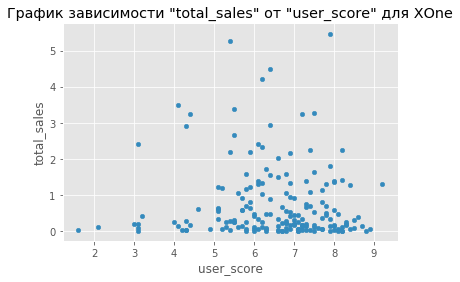

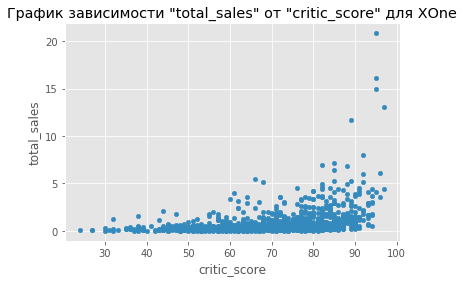

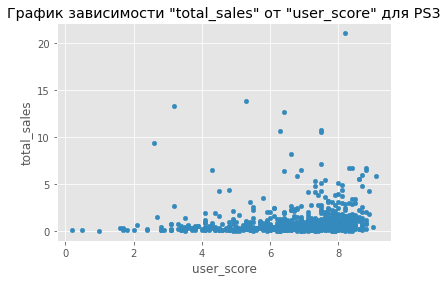

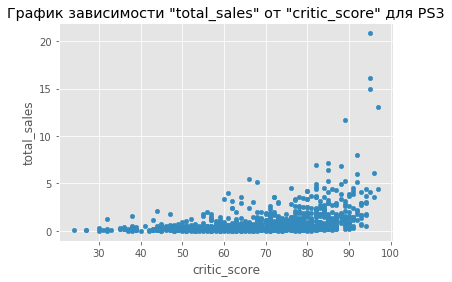

In [45]:
for platform_stat, platform_name in [[XOne_stat,'XOne'], [PS3_stat, 'PS3']]:
    platform_stat.query('user_score != 0').plot.scatter(
    x = 'user_score',
    y = 'total_sales',
    );
    plt.title(f'График зависимости "total_sales" от "user_score" для {platform_name}');
    PS2_stat.query('critic_score != 0').plot.scatter(
    x = 'critic_score',
    y = 'total_sales',
    );
    plt.title(f'График зависимости "total_sales" от "critic_score" для {platform_name}');

In [46]:
# рассчитаем коэффициент корреляции для каждой зависимости
for platform_stat, platform_name in [[XOne_stat,'XOne'], [PS3_stat, 'PS3']]:
    print(f'Для {platform_name}')
    print(f"Rоэффициент корреляции между 'total_sales' и 'user_score': {platform_stat['total_sales'].corr(platform_stat['user_score']):.4f}")
    print(f"Rоэффициент корреляции между 'total_sales' и 'critic_score': {platform_stat['total_sales'].corr(platform_stat['critic_score']):.4f}")
    print()

    

Для XOne
Rоэффициент корреляции между 'total_sales' и 'user_score': 0.1166
Rоэффициент корреляции между 'total_sales' и 'critic_score': 0.2748

Для PS3
Rоэффициент корреляции между 'total_sales' и 'user_score': 0.2746
Rоэффициент корреляции между 'total_sales' и 'critic_score': 0.3551



Взглянув на значения корреляции, которые мы рассчитали, понятно, что связи между этими значениями. Вывод, что, зачастую, игры, на которых удалось заработать больше обычного, не так очевиден. Это видно на графиках зависимости между общих сборов от оценки пользователей, ну это скорей говорит о том, что у людей очень разные вкусы. А вот зависимость между общими сборами и оценкой критикой подтверждает наш вывод. На этих графиков хорошо видно, что игры, которые заработали сильно больше остальных, имеют хорошую оценку.

Теперь предлагаю посмотреть на игры, разделив их по жанрам. Посмотрим, сколько игр каждого жанров существует. Рассчитаем общую прибыль игр каждого жанра.

In [47]:
# Сгруппируем игры по жанрам 
genre_stat = game_data.pivot_table(
    index = 'genre_name', values = 'total_sales', aggfunc = 'sum'
)
genre_stat.sort_values(by = 'total_sales', ascending = False, inplace = True)
genre_stat

,total_sales
genre_name,
Action,1648.43
Sports,1269.92
Shooter,979.32
Role-Playing,901.19
Misc,776.83
Racing,694.95
Platform,659.27
Fighting,419.80
Simulation,382.03


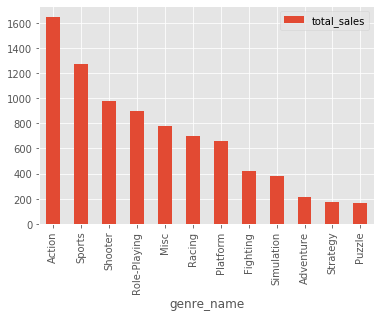

In [48]:
#Теперь построим графики распределения количества проданных игр и количество заработанных денег по жанрам
genre_stat.plot.bar();

Что мы видем на графике? Самый популярный жанр: 'Action', но он не слишкомдалеко ушел от ближайших сопреников: 'Sports' и 'Shooter'. Оказывается, самый нелюбимый жанр у игроков - 'Strategy', никогда бы не подумал. На графике нет резких скачков, количесьтво проданных игр каждого жанра плавно уменьшается от жанра к жанру. В центре даже есть жанры, где значение проданных игр почти равно.

### Вывод

Провели большое исследовательский анализ наших данных. Проанализировали ситуацию с платформами. Теперь мы знаем, что в среднем платформа актуальна около 10 лет, а продолжительность популярности около 5. Нашли способ прогнозирования продаж игр на следующий год. Определили платформы, которые могут принести хорошую прибыль в следующем году. Затем, используя математические вычисления, поняли, что оценки пользователя и критиков не влияют на количество продаж, но у популярных игр чаще всего хорошая оценка. В конце мы проанализировали игры по жанрам, построили рейтинг. На удивление мой любимый жанр игр: 'Strategy' - находится в конце нашего рейтинга. 

Теперь предлагаю перейти дальше и попробовать составить портрет пользователя каждого региона

## Составим портрет пользователя каждого региона

Для пользователя каждого региона (NA, EU, JP) определим:
* Самые популярные платформы (топ-5).
* Самые популярные жанры (топ-5).
* Проверим влияет ли рейтинг ESRB на продажи в отдельном регионе?

Будем брать каждый регион по отдельности и составлять для него портрет. Для удобства напишем функции, которые будут на вход получать название строки с продажами нужноо региона и строить нужный рейтинг.

In [49]:
# рейтинг самых популярных платформ в заданном регине
def top5_platform(data, columns):
    report = data.pivot_table(
        index = 'platform', values = columns, aggfunc = 'sum'
    ).sort_values(by = columns, ascending = False)
    report['%_of_total'] = (report[columns] / report[columns].sum()).round(2)
    return report.head()

In [50]:
# рейтинг самых популярных жанров в заданном регионе
def top5_genre(data, columns):
    report = data.pivot_table(
        index = 'genre_name', values = columns, aggfunc = 'sum'
    ).sort_values(by = columns, ascending = False)
    report['%_of_total'] = (report[columns] / report[columns].sum()).round(2)
    return report.head()

In [51]:
# сгруппировали игры по рейтингу
def addiction_from_ESRB(data, columns):
    report = data.query('rating != "unknown"').pivot_table(
        index = 'rating', values = columns, aggfunc = 'sum'
    ).sort_values(by = columns, ascending = False)
    report['%_of_total'] = (report[columns] / report[columns].sum()).round(2)
    return report

Наши алгоритмы готовы. Сначала составим портрет для игроков из Северной Америки.

In [52]:
# Самые популярные платформы
na_platform = top5_platform(game_data, 'na_sales')
na_platform

,na_sales,%_of_total
platform,,
X360,595.74,0.15
PS2,572.92,0.14
Wii,486.87,0.12
PS3,390.13,0.10
DS,380.31,0.09


In [53]:
# самые популярные жанры
na_genre = top5_genre(game_data, 'na_sales')
na_genre

,na_sales,%_of_total
genre_name,,
Action,815.32,0.20
Sports,657.61,0.16
Shooter,532.91,0.13
Misc,393.92,0.10
Platform,343.37,0.09


In [54]:
# количество проданных игр каждого рейтинга
na_rating = addiction_from_ESRB(game_data, 'na_sales')
na_rating

,na_sales,%_of_total
rating,,
E,1274.24,0.41
T,747.58,0.24
M,742.87,0.24
E10+,345.50,0.11
K-A,2.56,0.00
EC,1.53,0.00
AO,1.26,0.00
RP,0.00,0.00


Что можно сказать о геймерах из Северной Америки? Пользователи из Северной Америки предпочитают играть в игры на 'X360' и 'PS2', чуть меньше на 'Wii'. Топ-3 самых популярных жанра - это 'Action', 'Sports' и 'Shooter': в этом игроки из Северной Америки схожи с игроками со всего мира. Чаще всего они играют в игры рейтинга 'E'. А игры с рейтингом 'K-A', 'EC', 'AO' и 'RP' эти игроки почти не выбирают.

Переходим к составлению портрета для любителей поиграть из Европпы.

In [55]:
# Самые популярные платформы
eu_platforms = top5_platform(game_data, 'eu_sales')
eu_platforms

,eu_sales,%_of_total
platform,,
PS2,332.63,0.14
PS3,327.21,0.14
X360,268.32,0.11
Wii,258.32,0.11
PS,212.39,0.09


In [56]:
# самые популярные жанры
eu_genre = top5_genre(game_data, 'eu_sales')
eu_genre

,eu_sales,%_of_total
genre_name,,
Action,503.69,0.21
Sports,367.91,0.16
Shooter,311.31,0.13
Racing,230.32,0.10
Misc,209.69,0.09


In [57]:
# количество проданных игр каждого рейтинга
eu_rating = addiction_from_ESRB(game_data, 'eu_sales')
eu_rating

,eu_sales,%_of_total
rating,,
E,703.87,0.39
M,480.00,0.27
T,420.99,0.24
E10+,183.33,0.10
AO,0.61,0.00
K-A,0.27,0.00
EC,0.11,0.00
RP,0.03,0.00


А вот в Европе, в отличие от Северной Америки, сильнее любят playstation. На первый двух местах находятся приставки 'PS2' и 'PS3', а третье место, с небольшим разрывом (меньше процента) делят 'X360' (в Америке занимает первое место) и 'Wii'. Так же как в мире или в Америке, здесь самые популярные жанры - это 'Action', 'Sports' и 'Shooter. А пристрастие к играм разных рейтингов в Европе отличается, но совсем немного. Так же, как и в Америке, в Европе самый любимые игры - игры с рейтингом 'E'. И, снова, так же, как и в Америке, в Европе почти не покупают игры рейтинга 'K-A', 'EC', 'AO' или 'RP'.

Осталось нарисовать последний портрет. Что-то краски заканчиваются... Ладно, купим их по пути в Японию. Что-то мне подсказывает, что сейчас начнется самое интересное.

In [58]:
# Самые популярные платформы
jp_platforms = top5_platform(game_data, 'jp_sales')
jp_platforms

,jp_sales,%_of_total
platform,,
DS,175.00,0.15
PS,139.78,0.12
PS2,137.54,0.12
3DS,100.62,0.09
SNES,82.74,0.07


In [59]:
# самые популярные жанры
jp_genre = top5_genre(game_data, 'jp_sales')
jp_genre

,jp_sales,%_of_total
genre_name,,
Role-Playing,326.65,0.29
Action,148.22,0.13
Sports,112.67,0.10
Misc,100.27,0.09
Platform,89.28,0.08


In [60]:
# количество проданных игр каждого рейтинга
jp_rating = addiction_from_ESRB(game_data, 'jp_sales')
jp_rating

,jp_sales,%_of_total
rating,,
E,197.96,0.44
T,150.70,0.33
M,63.58,0.14
E10+,40.20,0.09
K-A,1.46,0.00
AO,0.00,0.00
EC,0.00,0.00
RP,0.00,0.00


Класс! А вот и новые лидеры. Любимые платформы для игр у японцев - это 'DS', 'PS' и 'PS2'. Из знакомых нам до этого в топ-5 входит лишь 'PS2'. В любимых жанров совпадений уже больше. На первом месте появляется новый жанр 'Role-Playing', остальные два занимают, уже известные нам, 'Action' и 'Sports'. В 'Shooter' японцы играть не любят. А вот с рейтингами ситуация почти такая же. Первые три места: 'E', 'T' и 'M'. А вот игры с рейтингом 'AO','EC' или 'RP' в Японии вообще не продаются.

### Вывод 

Составили портреты среднего пользователя каждого из трёх регионов (Северная Америка, Европа и Япония). Пользователи из Северная Америки и Европы имеют схожие пристрастия к играм. А вот при описании пользователя из Японии появляются новые названия. Не зря говорят, что Япония – другой мир.

## Проверяем гипотезы

Проверим две гипотезы:
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Для Начала рассмотрим первую.

Формируем нулевую гипотезу: Средние пользовательские рейтинги платформ Xbox One и PC равны.

Формируем альтернативную гипотезу, если не произойдет нулевая гипотеза, то произойдет следующее: Средние пользовательские рейтинги платформ Xbox One и PC различаются.

Использовать мы будем метод st.ttest_ind(). Значение st.ttest_ind().pvalue мы будем сравнивать со значением равным 0.05, так как он характеризует лишь 5% случаев, если 5% будут выбиваться из общей картины, это не будет повод отвергать гепотезу о равенстве.

In [61]:
# строим выборки, которые мы будем сравнивать
proceeds_from_XOne = game_data.query('platform == "XOne"')['user_score']
proceeds_from_PC = game_data.query('platform == "PC"')['user_score']

In [62]:
# Проверим равенство наших двух совакупностей и выведем результат

alpha = .05

results = st.ttest_ind(proceeds_from_XOne, proceeds_from_PC, equal_var = True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0004652379265680001
Отвергаем нулевую гипотезу


Вероятность того, что cредние пользовательские рейтинги платформ Xbox One и PC равны, слишком мала, меньше процента. Об этом нам говорит результат выполнения метода st.ttest_ind(), который проверяет две совокупности на равенство. Из-за этого мы подтверждаем альтернативную гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC различаются.

Теперь переходим к следующей гипотизе.

Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports равны.

Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports различаются.

In [63]:
# строим выборки, которые мы будем сравнивать
proceeds_from_action = game_data.query('genre_name == "Action"')['user_score']
proceeds_from_sports = game_data.query('genre_name == "Sports"')['user_score']

In [64]:
# Проверим равенство наших двух совакупностей и выведем результат

alpha = .05

results = st.ttest_ind(proceeds_from_action, proceeds_from_sports, equal_var = True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1884827974373375e-09
Отвергаем нулевую гипотезу


В этом случае мы снова отвергли нулевую гипотезу. Это значит, что средние пользовательские рейтинги жанров Action и Sports различаются.

### Вывод
Что можно сказать о работе в этом разделе? Все просто: 
* первую гипотезу: "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые", мы не отвергаем, так как одинаковые значения рейтингамы можем получить лишь 0.05% случаях.
* вторую гипотезу: "средние пользовательские рейтинги жанров Action и Sports разные." Её мы не можем отвергнуть, ведь процент случаев, когда пользовательский рейтинг у этих двух жанров схожий, равен значению меньше 1%.


## Вывод

Вот и подошла к концу наша работа. Первую часть работы мы обрабатывали наши данные. Сначала была предобработка, затем мы добавили новый столбец со значениями, которые использовали в анализе. Затем начался анализ. В нём мы составляли статистику, группировали наши данные по разным видам категорий и смотрели, как эти категории влияют на цену. Ещё мы сравнивали, как влияет разного рода рейтинг на количество проданных копий игры. После анализа мы принялись составлять портрет компьютерных игроков из разных стран. Что мы узнали? Интересы у игроков Европы и Северной Америки почти не отличались. А вот Японцы любят много необычного, в их портрете мы увидели в лидерах и новый приставки, и новые непонятные жанры. В последнем пункте мы проверяли две поставленные гипотезы о равенстве, используя метод st.ttest_ind(). Первую гипотезу: 'средние пользовательские рейтинги платформ Xbox One и PC одинаковые', мы отвергли. А вот вторую: 'средние пользовательские рейтинги жанров Action и Sports различаются', мы не смогли отвергнуть.

Подводя итоги, хочется провести большую черту, и кое-что написать. Давайте вспомним нашу задачу. А звучала она примерно так: 'вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании'.  Пиар отделу, при планировании рекламной компании, я советую сначала проанализировать все актуальные платформы, на которые выпускают игры, посмотреть на их популярность, спрогнозировать, сколько лет им осталось быть в списке 'актуальные' (в среднем этот период длится около 10 лет). Посмотреть, прошёл ли у данной платформы пик большого спроса (мы определили, что он в среднем длится 4-5 лет). Так же можно посмотреть, были ли у этой платформы предшественники, если да, то насколько успешно они себя показали. Проделав данную работу, я считаю, что именно эти факторы должны учитываться при планировании рекламной компании на следующий год для магазина по продажам игр. 